In [13]:
import pandas as pd
import sqlalchemy
from binance.client import Client
from binance import BinanceSocketManager


In [14]:
client =Client("yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe","lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO")

In [15]:
bsm=BinanceSocketManager(client)

In [16]:
socket=bsm.trade_socket("ETHBUSD")

In [20]:
while True:
    await socket.__aenter__()
    msg= await socket.recv()
    frame=createframe(msg)
    frame.to_sql("ETH",engine,if_exists="append",index=False)
    print(msg)

CancelledError: 

In [18]:
def createframe(msg):
    df=pd.DataFrame([msg])
    df=df.loc[:,["s","E","p"]]
    df.columns = (["symbols","Time","Price"])
    df.Price= df.Price.astype(float)
    df.Time= pd.to_datetime(df.Time,unit='ms')
    return df
    

In [19]:
createframe(msg)

NameError: name 'msg' is not defined

In [17]:
engine=sqlalchemy.create_engine("sqlite:///ETHBUSDstream.db")

### trading

In [2]:
import pandas as pd
import sqlalchemy
from binance.client import Client
from binance import BinanceSocketManager

In [3]:
client =Client("yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe","lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO")

In [4]:
engine=sqlalchemy.create_engine("sqlite:///ETHBUSDstream.db")


In [9]:
df=pd.read_sql("ETH",engine)
df

OperationalError: (sqlite3.OperationalError) near "ETH": syntax error
[SQL: ETH]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [7]:
df.Price.plot()

NameError: name 'df' is not defined

In [84]:
def startergy(entery,lookback,qty,open_position=False):
    while True:
        df=pd.read_sql("ETH",engine)
        lookbackperiod=df.iloc[int(lookback):]
        cumret=(lookbackperiod.Price.pct_change() +1).cumprod() -1
        if not open_position:
            if cumret[cumret.last_valid_index()] < entery:
                order = client.create_order(symbol='ETHBUSD',
                                           side='BUY',
                                           type='MARKET',
                                           quantity=qty)
                print(order)
                open_position=True
                break
        if open_position:
            while True:
                df=pd.read_sql("ETH",engine)
                sincebuy=df.loc[df.Time <
                               pd.to_datetime(order['transct_time'],unit='ms')]
                if len(sincebuy)>1:
                    sincebuyrate=(sincebuy.Price.pct_change()+1).cumprod() -1
                    lastentry=sincebuyrate[sincebuyrate.last_valid_index()]
                    if lastentry > 0.0015 or lastentry< -0.0015:
                        order =client.create_order(symbol='ETHBUSD',
                                                   side='SELL',
                                                   type='MARKET',
                                                   quantity=qty)
                        print(order)
                        break
                    
            

In [85]:
# startergy(0.00532170,10,0.00532170)
startergy(0.1,0,0.0154)

{'symbol': 'ETHBUSD', 'orderId': 5943488344, 'orderListId': -1, 'clientOrderId': 'sTazSTsJBFznjRwEya0DHX', 'transactTime': 1664861938073, 'price': '0.00000000', 'origQty': '0.01540000', 'executedQty': '0.01540000', 'cummulativeQuoteQty': '20.43179600', 'status': 'FILLED', 'timeInForce': 'GTC', 'type': 'MARKET', 'side': 'BUY', 'fills': [{'price': '1326.74000000', 'qty': '0.01540000', 'commission': '0.00001540', 'commissionAsset': 'ETH', 'tradeId': 404526389}]}


### RSI && MACD Trading

In [86]:
import pandas as pd
import numpy as np
import ta
from binance.client import Client
import time

In [87]:
client =Client("yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe","lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO")

In [88]:
def getminutedatal (symbol, interval, lookback):
    frame = pd.DataFrame(client.get_historical_klines(symbol,interval,lookback+ ' min ago UTC'))
    frame =frame.iloc[:,:6]

    frame.columns=["Time", "Open", "High", "Low", "Close" , "Volume" ]
    
    frame.Time = pd.to_datetime(frame["Time"], unit='ms')
    frame=frame.set_index("Time")

    frame=frame.astype(float)

    return frame

In [89]:
df=getminutedatal('ETHBUSD','1m','100')

In [90]:
df

,Open,High,Low,Close,Volume
Time,,,,,
2022-10-04 04:00:00,1329.37,1329.72,1329.37,1329.65,77.9366
2022-10-04 04:01:00,1329.65,1330.22,1329.65,1330.11,232.2969
2022-10-04 04:02:00,1330.12,1330.44,1329.04,1329.19,132.0737
2022-10-04 04:03:00,1329.18,1329.18,1328.42,1328.60,633.6099
2022-10-04 04:04:00,1328.59,1328.75,1328.33,1328.33,75.0902
...,...,...,...,...,...
2022-10-04 05:35:00,1326.42,1326.70,1326.42,1326.62,68.4158
2022-10-04 05:36:00,1326.63,1326.68,1326.21,1326.43,197.8634
2022-10-04 05:37:00,1326.43,1326.43,1325.74,1326.03,120.1941


In [91]:
def applyrsi(df):
    df['%k']=ta.momentum.stoch(df.High,df.Low,df.Close,window=14,smooth_window=3)
    df['%D']=df['%k'].rolling(3).mean()
    df['rsi']=ta.momentum.rsi(df.Close,window=14)
    df['macd']=ta.trend.macd_diff(df.Close)
    df.dropna(inplace=True)

In [92]:
applyrsi(df)

In [93]:
df

,Open,High,Low,Close,Volume,%k,%D,rsi,macd
Time,,,,,,,,,
2022-10-04 04:33:00,1328.19,1330.00,1328.19,1329.93,903.3593,82.671480,34.055355,60.309128,-0.031676
2022-10-04 04:34:00,1329.93,1330.00,1329.59,1329.85,177.6403,79.783394,60.649819,59.522680,0.045858
2022-10-04 04:35:00,1329.84,1330.00,1329.41,1329.94,14.0551,83.032491,81.829122,60.152227,0.097141
2022-10-04 04:36:00,1329.93,1329.94,1329.41,1329.93,113.3387,82.671480,81.829122,60.040489,0.122678
2022-10-04 04:37:00,1329.93,1335.63,1329.93,1332.22,3367.2541,57.321652,74.341874,72.595028,0.277240
...,...,...,...,...,...,...,...,...,...
2022-10-04 05:35:00,1326.42,1326.70,1326.42,1326.62,68.4158,6.614173,5.091864,28.990640,-0.566085
2022-10-04 05:36:00,1326.63,1326.68,1326.21,1326.43,197.8634,3.622047,4.566929,28.128721,-0.537237
2022-10-04 05:37:00,1326.43,1326.43,1325.74,1326.03,120.1941,4.647436,4.961219,26.352405,-0.513584


In [94]:
class signal:
    
    def __init__(self,df,lags):
        self.df=df
        self.lags=lags
    def getrigger(self):
        dfx=pd.DataFrame()
        for i in range(self.lags + 1):
            mask = (self.df['%k'].shift(i)<20) & (self.df['%D'].shift(i)<20) 
            dfx= dfx.append(mask,ignore_index=True)
            return dfx.sum(axis=0)
    def decide(self):
        self.df['trigger']=np.where(self.getrigger(),1,0)
        self.df['Buy']= np.where((self.df.trigger)&(self.df['%k'].between(20,80))&(self.df['%D'].between(20,80))&(self.df.rsi>50)&(self.df.macd>0),1,0)
        
        

In [95]:
inst = signal(df,25)

In [96]:
inst.decide()

In [97]:
df.Buy.unique()

array([0])

In [98]:
df[df["trigger"] == 1]

,Open,High,Low,Close,Volume,%k,%D,rsi,macd,trigger,Buy
Time,,,,,,,,,,,
2022-10-04 04:46:00,1329.50,1329.73,1329.01,1329.13,95.2630,12.634409,19.105087,45.361962,-0.223694,1,0
2022-10-04 04:47:00,1329.13,1329.90,1329.02,1329.90,394.5724,13.444109,16.452539,50.732598,-0.204024,1,0
2022-10-04 04:48:00,1329.89,1329.97,1329.16,1329.60,68.8434,8.912387,11.663635,48.723130,-0.204026,1,0
2022-10-04 04:49:00,1329.60,1329.71,1329.10,1329.11,34.7975,1.510574,7.955690,45.549632,-0.228019,1,0
2022-10-04 04:50:00,1329.10,1329.53,1328.82,1329.39,276.9499,8.370044,6.264335,47.648006,-0.216131,1,0
2022-10-04 04:51:00,1329.40,1329.40,1329.04,1329.05,70.9844,4.693878,4.858165,45.361987,-0.221452,1,0
2022-10-04 04:52:00,1329.06,1329.15,1328.96,1329.02,86.5178,5.167959,6.077293,45.156124,-0.216991,1,0
2022-10-04 04:53:00,1329.01,1329.23,1328.88,1328.91,32.6940,2.325581,4.062473,44.361163,-0.211244,1,0
2022-10-04 04:54:00,1328.91,1329.32,1328.91,1329.31,67.7931,12.661499,6.718346,47.949599,-0.171964,1,0


In [99]:
df.trigger.unique()

array([0, 1])

In [100]:
df.Buy = 1

In [101]:
def strategy(pair,qty,open_position=False):
    df=getminutedatal('ETHBUSD','1m','100')
    applyrsi(df)
    inst = signal(df,25)
    inst.decide()
    print(f" Current Close is:" + str(df.Close.iloc[-1]))
    if df.Buy.iloc[-1]:
        order = client.create_order(symbol=pair,side='BUY',type='MARKET',quantity=qty)
        print(order)
        buyprice = float(order['fills'][0]['price'])
        open_position = True
    while open_position:
        time.sleep(0.5)
        df=getminutedatal('pair','1m','2')
        print(f" Current Close is" + str(df.Close.iloc[-1]))
        print(f" Current Target is" + str(buyprice * 1.005))
        print(f" Current Stop is" + str(buyprice * 0.998))
        if  df.Close[-1]<= buyprice * 0.995 or df.Close[-1]>= buyprice * 1.005:
            order = client.create_order(symbol=pair,side='SELL',type='MARKET',quantity=qty)
            print(order)
            break
                
                

In [102]:
strategy('ETHBUSD',0.0154)

 Current Close is:1326.19


In [103]:
while True:
    strategy('ETHBUSD',0.0154)
    time.sleep(0.5)

 Current Close is:1326.2
 Current Close is:1326.2
 Current Close is:1326.2
 Current Close is:1326.5
 Current Close is:1326.58
 Current Close is:1326.59
 Current Close is:1326.59
 Current Close is:1326.78
 Current Close is:1326.79
 Current Close is:1326.79
 Current Close is:1326.79
 Current Close is:1326.79
 Current Close is:1326.78
 Current Close is:1326.78
 Current Close is:1326.79
 Current Close is:1326.79
 Current Close is:1326.79
 Current Close is:1326.85
 Current Close is:1326.86
 Current Close is:1326.86
 Current Close is:1326.86
 Current Close is:1326.86
 Current Close is:1326.86
 Current Close is:1326.94
 Current Close is:1326.94
 Current Close is:1327.07
 Current Close is:1327.07
 Current Close is:1327.1
 Current Close is:1327.1
 Current Close is:1327.19
 Current Close is:1327.19
 Current Close is:1327.35
 Current Close is:1327.52
 Current Close is:1327.52
 Current Close is:1327.52


KeyboardInterrupt: 

### SMA Trading

In [20]:
import nest_asyncio
nest_asyncio.apply()

In [21]:
import pandas as pd
import asyncio
from binance.client import Client
from binance import BinanceSocketManager
import numpy as np

In [22]:
client =Client("yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe","lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO")

In [23]:
ST =7
LT =25

In [24]:
def getsmaoutput(symbol,LT):
    df=pd.DataFrame(client.get_historical_klines(symbol,'1d',str(LT)+'days ago UTC','1 day ago UTC'))
    closes=pd.DataFrame(df[4])
    closes.columns =["Close"]
    closes['ST']=closes.Close.rolling(ST-1).sum()
    closes['LT']=closes.Close.rolling(LT-1).sum()
    closes.dropna(inplace=True)
    return closes
    

In [25]:
historical = getsmaoutput('ETHBUSD',LT)

In [26]:
historical

,Close,ST,LT
23,1279.86000000,7892.16,31728.99


In [27]:
def livesma(hist,live):
    liveST=(hist['ST'].values+ live.Price.values) / ST
    liveLT=(hist['LT'].values+ live.Price.values) / LT
    return liveST,liveLT
    

In [28]:
def createframe(msg):
    df=pd.DataFrame([msg])
    df=df.loc[:,["s","E","p"]]
    df.columns = (["symbols","Time","Price"])
    df.Price= df.Price.astype(float)
    df.Time= pd.to_datetime(df.Time,unit='ms')
    return df

In [31]:
async def main (coin,qty,SL_limit,open_position=False):
    bm= BinanceSocketManager(client)
    ts=bm.trade_socket(coin)
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            if res:
                frame = createframe(res)
                print(frame)
                liveST,liveLT = livesma(historical,frame)
                if ((liveST) > (liveLT)).all() and not open_position:
                    order = client.create_order(symbol=coin,side='BUY',type='MARKET',quantity=qty)
                    print(order)
                    buyprice=float(Order['fills'][0]['price'])
                    open_position= True
                if open_position:
                    if frame.Price[0]< buyprice * SL_limit or frame.Price[0]> 1.02 *buyprice:
                        order = client.create_order(symbol=coin,side='SELL',type='MARKET',quantity=qty)
                        print(order)
                        loop.stop()

                        

In [32]:
if __name__ == "__main__":
    loop= asyncio.get_event_loop()
    loop.run_until_complete(main('ETHBUSD',0.0154,0.50))

KeyboardInterrupt: 

### trade


In [33]:
import os
import sqlalchemy
from binance.client import Client
from binance.enums import *
from binance.exceptions import BinanceAPIException, BinanceOrderException

In [34]:
client =Client("yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe","lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO")

In [35]:
engine=sqlalchemy.create_engine("sqlite:///ETHBUSDstream.db")

In [36]:
btc_price = client.get_symbol_ticker(symbol="ETHBUSD")
print(btc_price)
print(btc_price["price"])

{'symbol': 'ETHBUSD', 'price': '1298.90000000'}
1298.90000000


In [37]:
import btalib
import pandas as pd

# load DataFrame
btc_df =pd.read_sql('ETH',engine)
btc_df.set_index('Time', inplace=True)
btc_df.index = pd.to_datetime(btc_df.index, unit='ms')

# calculate 20 moving average using Pandas
btc_df['20sma'] = btc_df.Price.rolling(20).mean()

OperationalError: (sqlite3.OperationalError) near "ETH": syntax error
[SQL: ETH]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [6]:
btc_df

,symbols,Price,20sma
Time,,,
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN
...,...,...,...
2022-10-03 13:40:04.287,ETHBUSD,1299.12,1299.2595
2022-10-03 13:40:04.287,ETHBUSD,1299.09,1299.2455
2022-10-03 13:40:04.287,ETHBUSD,1299.08,1299.2310


In [7]:
max_val = btc_df.Price['2022'].max()

In [8]:
 max_val

1299.92

In [9]:
sma = btalib.sma(btc_df.Price)
print(sma.df)

                                 sma
Time                                
2022-10-03 13:39:57.671          NaN
2022-10-03 13:39:57.671          NaN
2022-10-03 13:39:57.671          NaN
2022-10-03 13:39:57.671          NaN
2022-10-03 13:39:57.671          NaN
...                              ...
2022-10-03 13:40:04.287  1299.320667
2022-10-03 13:40:04.287  1299.307333
2022-10-03 13:40:04.287  1299.293667
2022-10-03 13:40:04.287  1299.279667
2022-10-03 13:40:04.287  1299.265667

[72 rows x 1 columns]


In [10]:
btc_df['sma'] = btalib.sma(btc_df.Price, period=20).df
btc_df

,symbols,Price,20sma,sma
Time,,,,
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN
...,...,...,...,...
2022-10-03 13:40:04.287,ETHBUSD,1299.12,1299.2595,1299.2595
2022-10-03 13:40:04.287,ETHBUSD,1299.09,1299.2455,1299.2455
2022-10-03 13:40:04.287,ETHBUSD,1299.08,1299.2310,1299.2310


In [11]:
rsi = btalib.rsi(btc_df, period=14)
rsi
print(rsi.df.rsi[-1])

2.953846087844184


In [12]:
macd = btalib.macd(btc_df, pfast=20, pslow=50, psignal=13)
macd

In [13]:
btc_df = btc_df.join([rsi.df, macd.df])
btc_df

,symbols,Price,20sma,sma,rsi,macd,signal,histogram
Time,,,,,,,,
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-03 13:39:57.671,ETHBUSD,1299.72,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-10-03 13:40:04.287,ETHBUSD,1299.07,1299.2015,1299.2015,2.953846,-0.147790,-0.132808,-0.014982
2022-10-03 13:40:04.287,ETHBUSD,1299.07,1299.2015,1299.2015,2.953846,-0.149563,-0.135201,-0.014362
2022-10-03 13:40:04.287,ETHBUSD,1299.07,1299.2015,1299.2015,2.953846,-0.151359,-0.137509,-0.013849


In [19]:
buy_order_limit = client.create_order(symbol="ETHBUSD",side="BUY",type="MARKET",quantity =0.0154)
buy_order_limit

BinanceAPIException: APIError(code=-2010): Account has insufficient balance for requested action.

In [17]:
cancel = client.cancel_order(symbol='ETHBUSD', orderId=buy_order_limit['orderId'])
cancel

KeyError: 'orderId'

In [ ]:
buy_limit = client.order_limit_buy(symbol='ETHBUSD', quantity=100, price=200)

In [ ]:
market_order = client.order_market_sell(symbol='ETHBUSD', quantity=100)


In [ ]:
buy_order = client.create_test_order(symbol='ETHBUSD', side='BUY', type='MARKET', quantity=100)


In [ ]:
buy_order = client.create_test_order(symbol='ETHBUSD', side=SIDE_BUY, type=ORDER_TYPE_MARKET, quantity=100)


In [ ]:
info = client.get_symbol_info('ETHBUSD')


In [ ]:
print(info['orderTypes'])

In [ ]:
def topup_bnb(min_balance: float, topup: float):
    bnb_balance = client.get_asset_balance(asset='BNB')
    bnb_balance = float(bnb_balance['free'])
    if bnb_balance < min_balance:
        qty = round(topup - bnb_balance, 5)
        print(qty)
        order = client.order_market_buy(symbol='ETHUSDT', quantity=qty)
        return order
    return False

In [ ]:
min_balance = 1.0
topup = 2.5
order = topup_bnb(min_balance, topup)

## NUERAL NETWORK

In [38]:
import os
import sqlalchemy
from binance.client import Client
from binance.enums import *
from binance.exceptions import BinanceAPIException, BinanceOrderException
import numpy as np
import pandas as pd
import warnings
import yfinance as yf
import ta
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cycler

In [39]:
color= cycler('color',['#669FEE','#66EE91','#9988DD','#EECC55','#88BB44','#FFBBBB'])
plt.rc('figure',facecolor='#313233')
plt.rc("axes",facecolor='#313233',edgecolor="none",axisbelow=True,grid=True,prop_cycle=color,labelcolor="grey")
plt.rc('grid',color='474A4A',linestyle='solid')
plt.rc('xtick',color='grey')
plt.rc('ytick',direction='out',color='grey')
plt.rc('legend',facecolor='#313233',edgecolor='#313233')
plt.rc('text',color='#C9C9C9')

In [40]:
def feature_eng(df):
    df_copy=df.copy()
    df_copy["volume"]=df["close"].pct_change(1)
    df_copy["SMA 15"] = df[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df[["close"]].rolling(60).mean().shift(1)
    df_copy["MSD 10"] = df[["volume"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df[["volume"]].rolling(30).std().shift(1)
    Rsi=ta.momentum.RSIIndicator(df["close"],window=14,fillna=False)
    df_copy["rsi"]=Rsi.rsi()
    return df_copy.dropna()

In [41]:
def preprocessing(symbol):
    ticker_list=["BTC-USD"]
    df=yf.download(ticker_list).dropna()
    df.columns=['open','high','low','close','adj close','volume']
    df.index.name = 'time'
    del df['adj close']
    return df
    

In [42]:
df= preprocessing("BTC-USD")
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
time,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2022-10-08,19546.328125,19601.695312,19299.414062,19416.568359,16437423167
2022-10-09,19417.478516,19542.539062,19349.259766,19446.425781,16837262532
2022-10-10,19446.416016,19515.466797,19102.978516,19141.484375,27425022774


In [43]:
dfc=feature_eng(df)
dfc

,open,high,low,close,volume,SMA 15,SMA 60,MSD 10,MSD 30,rsi
time,,,,,,,,,,
2014-11-16,374.730011,390.799011,374.601990,387.881989,0.031236,360.166400,373.194417,1.549235e+07,1.125893e+07,55.885665
2014-11-17,388.348999,410.199005,377.502014,387.407990,-0.001222,364.308600,372.036884,1.601604e+07,1.129027e+07,55.714363
2014-11-18,387.785004,392.402008,371.117004,375.197998,-0.031517,368.409666,371.419683,1.638190e+07,1.193345e+07,51.348107
2014-11-19,373.895996,386.480988,373.895996,380.554993,0.014278,371.585933,371.093050,1.485602e+07,1.184613e+07,53.085274
2014-11-20,380.307007,382.024994,356.781006,357.839996,-0.059689,374.923466,370.620567,1.519863e+07,1.182404e+07,45.643197
...,...,...,...,...,...,...,...,...,...,...
2022-10-08,19546.328125,19601.695312,19299.414062,19416.568359,-0.006665,19452.077604,20674.525293,1.033370e+10,9.726929e+09,46.444609
2022-10-09,19417.478516,19542.539062,19349.259766,19446.425781,0.001538,19460.006250,20612.062793,9.307614e+09,1.039883e+10,46.790906
2022-10-10,19446.416016,19515.466797,19102.978516,19141.484375,-0.015681,19493.967187,20537.042513,9.393733e+09,1.074108e+10,43.684077


In [44]:
dfc.columns

Index(['open', 'high', 'low', 'close', 'volume', 'SMA 15', 'SMA 60', 'MSD 10',
       'MSD 30', 'rsi'],
      dtype='object')

In [45]:
split=int(0.85*len(dfc))

xtrain=dfc[['SMA 15', 'SMA 60', 'MSD 10','MSD 30', 'rsi']].iloc[:split:,:]
ytrain=dfc[["volume"]].iloc[:split:,:]


xtest=dfc[['SMA 15', 'SMA 60', 'MSD 10','MSD 30', 'rsi']].iloc[split:,:]
ytest=dfc[["volume"]].iloc[split:,:]

In [46]:
ytrain

,volume
time,
2014-11-16,0.031236
2014-11-17,-0.001222
2014-11-18,-0.031517
2014-11-19,0.014278
2014-11-20,-0.059689
...,...
2021-07-31,-0.014427
2021-08-01,-0.039670
2021-08-02,-0.019336


In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
sc= StandardScaler()

xtrain_sc= sc.fit_transform(xtrain)
xtest_sc= sc.transform(xtest)

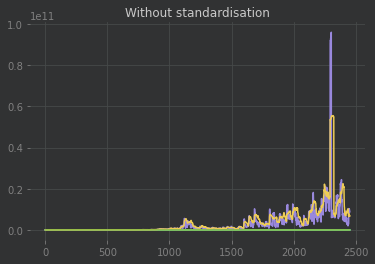

In [49]:
plt.plot(xtrain.values)
plt.title("Without standardisation")
plt.show()

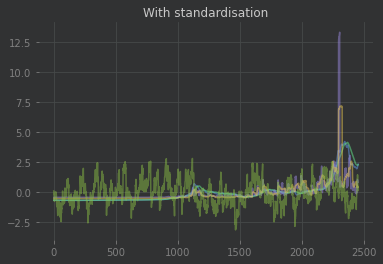

In [50]:
plt.plot(xtrain_sc[:,0:15],alpha=0.5)
plt.title("With standardisation")
plt.show()

In [51]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nb_hidden_layers =2 

In [52]:
regressor = Sequential()
regressor.add(Dense(25,input_shape=(xtest_sc.shape[1],),activation="relu"))

In [53]:
for i in range(1,nb_hidden_layers):
    regressor.add(Dense(int(25/i),activation="relu"))
regressor.add(Dense(1,activation="linear"))

regressor.compile(loss="mse",optimizer="adam")
regressor.fit(xtrain_sc,ytrain,epochs=10)

Epoch 1/10
77/77 [==============================] - 3s 3ms/step - loss: 0.0112
Epoch 2/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 3/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 4/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 5/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 6/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 7/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 8/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 9/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 10/10
77/77 [==============================] - 0s 2ms/step - loss: 0.0014


In [54]:
nb_hidden_layers =5 
regressor = Sequential()
regressor.add(Dense(500,input_shape=(xtest_sc.shape[1],),activation="relu"))
for i in range(1,nb_hidden_layers):
    regressor.add(Dense(int(500/i),activation="relu"))
regressor.add(Dense(1,activation="linear"))
regressor.compile(loss="mse",optimizer="adam")
regressor.fit(xtrain_sc,ytrain,validation_data=(xtest_sc,ytest),epochs=50)

Epoch 1/50
77/77 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 2/50
77/77 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/50
77/77 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/50
77/77 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 5/50
77/77 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/50
77/77 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/50
77/77 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/50
77/77 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
77/77 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/50
77/77 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.8592e-04
Epoch 11/50
77

<AxesSubplot:>

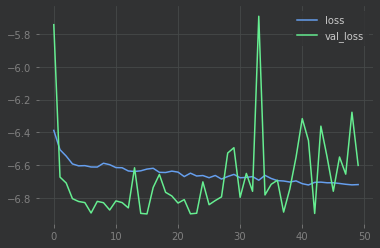

In [18]:
np.log(pd.DataFrame(regressor.history.history)).plot()

In [19]:
from tensorflow.keras.callbacks import EarlyStopping 

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nb_hidden_layers =2 
regressor = Sequential()
regressor.add(Dense(25,input_shape=(xtest_sc.shape[1],),activation="relu"))

for i in range(1,nb_hidden_layers):
    regressor.add(Dense(int(25/i),activation="relu"))
regressor.add(Dense(1,activation="linear"))

regressor.compile(loss="mse",optimizer="adam")
regressor.fit(xtrain_sc,ytrain,epochs=10)

early_stop = EarlyStopping(verbose=1,patience=5)
regressor.fit(xtrain_sc,ytrain,validation_data=(xtest_sc,ytest),epochs=100,callbacks=[early_stop])


Epoch 1/10
77/77 [==============================] - 1s 1ms/step - loss: 0.0071
Epoch 2/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 3/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 4/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 5/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 6/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 7/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 8/10
77/77 [==============================] - 0s 997us/step - loss: 0.0016
Epoch 9/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 10/10
77/77 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 1/100
77/77 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 3/1

<AxesSubplot:>

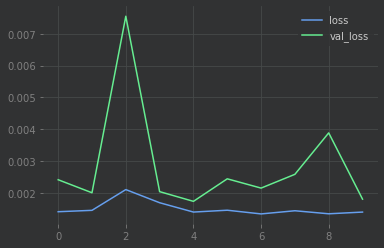

In [20]:
pd.DataFrame(regressor.history.history).plot()

In [3]:
#Automized code
def feature_eng(df):
    df_copy=df.copy()
    df_copy["volume"]=df["close"].pct_change(1)
    df_copy["SMA 15"] = df[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df[["close"]].rolling(60).mean().shift(1)
    df_copy["MSD 10"] = df[["volume"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df[["volume"]].rolling(30).std().shift(1)
    Rsi=ta.momentum.RSIIndicator(df["close"],window=14,fillna=False)
    df_copy["rsi"]=Rsi.rsi()
    return df_copy.dropna()

def preprocessing(symbol):
    ticker_list=["BTC-USD"]
    df=yf.download(ticker_list).dropna()
    df.columns=['open','high','low','close','adj close','volume']
    df.index.name = 'time'
    del df['adj close']
    return df


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping 
def Ann(symbol,nb_neuron=25,nb_hidden_layers=2,nb_model=None):
    df= preprocessing(symbol)
    dfc=feature_eng(df)
    split=int(0.85*len(dfc))
    split_val=int(0.95*len(dfc))

    xtrain=dfc[['SMA 15', 'SMA 60', 'MSD 10','MSD 30', 'rsi']].iloc[:split:,:]
    ytrain=dfc[["volume"]].iloc[:split:,:]


    xtest=dfc[['SMA 15', 'SMA 60', 'MSD 10','MSD 30', 'rsi']].iloc[split:,:]
    ytest=dfc[["volume"]].iloc[split:,:]
    
    from sklearn.preprocessing import StandardScaler
    sc= StandardScaler()

    xtrain_sc= sc.fit_transform(xtrain)
    xtest_sc= sc.transform(xtest)
    regressor = Sequential()
    regressor.add(Dense(25,input_shape=(xtest_sc.shape[1],),activation="relu"))
    
    for i in range(1,nb_hidden_layers):
        regressor.add(Dense(int(25/i),activation="relu"))
    regressor.add(Dense(1,activation="linear"))

    regressor.compile(loss="mse",optimizer="adam")
    early_stop = EarlyStopping(verbose=1,patience=5)
    regressor.fit(xtrain_sc,ytrain,validation_data=(xtest_sc,ytest),epochs=100,callbacks=[early_stop])
    
    
    dfc['prediction']=regressor.predict(np.concatenate((xtrain_sc,xtest_sc),axis=0))
    
    dfc['strategy']=np.sign(dfc['prediction'].shift(1)) *dfc["volume"]
    dfc['volume'] =dfc['strategy']
    
    if nb_model!=None:
        regressor.save_weights(f"Weigth_Ann/Ann n{nb_model}")
        return dfc['strategy'].iloc[split:split_val], dfc['strategy'].iloc[split_val:]
    else:
        return dfc['strategy'].iloc[split:split_val], dfc['strategy'].iloc[split_val:]

In [22]:

sr =Ann("BTC-USD",nb_model=15)
sr

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0120 - val_loss: 0.0110
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 3/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 10/100
77/77 [====================

(time
 2021-07-26    0.056219
 2021-07-27    0.055424
 2021-07-28    0.014946
 2021-07-29    0.000313
 2021-07-30    0.055666
                 ...   
 2022-05-05   -0.078674
 2022-05-06   -0.014606
 2022-05-07   -0.014954
 2022-05-08   -0.040637
 2022-05-09   -0.110464
 Name: strategy, Length: 288, dtype: float64,
 time
 2022-05-10   -0.023961
 2022-05-11   -0.067258
 2022-05-12    0.003850
 2022-05-13    0.008102
 2022-05-14    0.027940
                 ...   
 2022-09-26    0.022368
 2022-09-27   -0.005833
 2022-09-28    0.016544
 2022-09-29    0.007532
 2022-09-30   -0.014245
 Name: strategy, Length: 144, dtype: float64)

In [68]:
from tqdm import tqdm

In [69]:
return_test =[]
return_val=[]

In [70]:
for i in tqdm(range(100)):
    test ,val =Ann("BTC-USD",nb_model=15)
    return_test.append(test)
    return_val.append(val)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0476 - val_loss: 0.0300
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0229
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0198
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0114
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0104
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0067
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0063
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 10/100
77/77 [====================

  1%|▊                                                                                 | 1/100 [00:05<09:15,  5.61s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0245 - val_loss: 0.0213
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0113
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0090
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0069
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 10/100
77/77 [====================

  2%|█▋                                                                                | 2/100 [00:10<09:00,  5.51s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 7ms/step - loss: 0.0145 - val_loss: 0.0039
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/100
77/77 [====================

  3%|██▍                                                                               | 3/100 [00:15<08:21,  5.17s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0170 - val_loss: 0.0131
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0084
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0091
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0079
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0083
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0072
Epoch 10/100
77/77 [====================

  4%|███▎                                                                              | 4/100 [00:25<10:51,  6.79s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0495
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0106
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 10/100
77/77 [====================

  5%|████                                                                              | 5/100 [00:33<11:05,  7.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0049
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

  6%|████▉                                                                             | 6/100 [00:47<14:20,  9.15s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/100
77/77 [====================

  7%|█████▋                                                                            | 7/100 [00:51<11:51,  7.65s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 00008: early stopping


  8%|██████▌                                                                           | 8/100 [00:55<09:52,  6.44s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0436 - val_loss: 0.0101
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0071
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0096
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 10/100
77/77 [====================

  9%|███████▍                                                                          | 9/100 [01:00<09:07,  6.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0078 - val_loss: 0.0195
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0096
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0052
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 10/100
77/77 [====================

 10%|████████                                                                         | 10/100 [01:06<09:03,  6.04s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0076 - val_loss: 0.0060
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 10/100
77/77 [====================

 11%|████████▉                                                                        | 11/100 [01:10<07:58,  5.38s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0137 - val_loss: 0.0110
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
77/77 [====================

 12%|█████████▋                                                                       | 12/100 [01:14<07:22,  5.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0370 - val_loss: 0.0456
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0119
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/100
77/77 [====================

 13%|██████████▌                                                                      | 13/100 [01:19<07:15,  5.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0146
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0087
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 10/100
77/77 [====================

 14%|███████████▎                                                                     | 14/100 [01:23<06:52,  4.80s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0102
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0067
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/100
77/77 [====================

 15%|████████████▏                                                                    | 15/100 [01:29<07:03,  4.98s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0207 - val_loss: 0.0107
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 16%|████████████▉                                                                    | 16/100 [01:34<07:11,  5.14s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0255
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0058
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0055
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 10/100
77/77 [====================

 17%|█████████████▊                                                                   | 17/100 [01:39<06:55,  5.00s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0251 - val_loss: 0.0163
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0092
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0075
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 18%|██████████████▌                                                                  | 18/100 [01:42<06:03,  4.44s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0064
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 19%|███████████████▍                                                                 | 19/100 [01:47<06:08,  4.54s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0020
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
77/77 [====================

 20%|████████████████▏                                                                | 20/100 [01:52<06:12,  4.66s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0347 - val_loss: 0.0092
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/100
77/77 [====================

 21%|█████████████████                                                                | 21/100 [01:56<06:01,  4.58s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0205 - val_loss: 0.0118
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0072
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 10/100
77/77 [====================

 22%|█████████████████▊                                                               | 22/100 [02:01<06:09,  4.74s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0120 - val_loss: 0.0101
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 23%|██████████████████▋                                                              | 23/100 [02:06<06:14,  4.87s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0016
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/100
77/77 [====================

 24%|███████████████████▍                                                             | 24/100 [02:16<07:57,  6.28s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0136 - val_loss: 0.0084
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/100
77/77 [====================

 25%|████████████████████▎                                                            | 25/100 [02:22<07:51,  6.29s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0054
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/100
77/77 [====================

 26%|█████████████████████                                                            | 26/100 [02:27<07:11,  5.83s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0115
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 10/100
77/77 [====================

 27%|█████████████████████▊                                                           | 27/100 [02:33<07:02,  5.78s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0564 - val_loss: 0.0193
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0071
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/100
77/77 [====================

 28%|██████████████████████▋                                                          | 28/100 [02:37<06:32,  5.46s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0241 - val_loss: 0.0105
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0057
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/100
77/77 [====================

 29%|███████████████████████▍                                                         | 29/100 [02:43<06:32,  5.53s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0156 - val_loss: 0.0110
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 10/100
77/77 [====================

 30%|████████████████████████▎                                                        | 30/100 [02:48<06:13,  5.34s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0257
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0113
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0076
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0053
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0046
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 10/100
77/77 [====================

 31%|█████████████████████████                                                        | 31/100 [02:58<07:55,  6.88s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0048
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/100
77/77 [====================

 32%|█████████████████████████▉                                                       | 32/100 [03:02<06:32,  5.78s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0149
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 10/100
77/77 [====================

 33%|██████████████████████████▋                                                      | 33/100 [03:07<06:18,  5.65s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1571 - val_loss: 0.0113
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0063
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0052
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0058
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 10/100
77/77 [====================

 34%|███████████████████████████▌                                                     | 34/100 [03:10<05:30,  5.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0082
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 10/100
77/77 [====================

 35%|████████████████████████████▎                                                    | 35/100 [03:14<05:05,  4.70s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0242 - val_loss: 0.0051
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0038
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
77/77 [====================

 36%|█████████████████████████████▏                                                   | 36/100 [03:19<04:49,  4.52s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1804 - val_loss: 0.0300
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0105
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0111
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0090
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0073
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0064
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0054
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 10/100
77/77 [====================

 37%|█████████████████████████████▉                                                   | 37/100 [03:25<05:12,  4.95s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0152
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 10/100
77/77 [====================

 38%|██████████████████████████████▊                                                  | 38/100 [03:28<04:34,  4.43s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0313 - val_loss: 0.0340
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0114
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/100
77/77 [====================

 39%|███████████████████████████████▌                                                 | 39/100 [03:31<04:17,  4.22s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0153
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 10/100
77/77 [====================

 40%|████████████████████████████████▍                                                | 40/100 [03:34<03:48,  3.82s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0108
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 10/100
77/77 [====================

 41%|█████████████████████████████████▏                                               | 41/100 [03:38<03:46,  3.83s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 5ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/100
77/77 [====================

 42%|██████████████████████████████████                                               | 42/100 [03:41<03:24,  3.53s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0178 - val_loss: 0.0045
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/100
77/77 [====================

 43%|██████████████████████████████████▊                                              | 43/100 [03:46<03:45,  3.95s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0118 - val_loss: 0.0032
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0038
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/100
77/77 [====================

 44%|███████████████████████████████████▋                                             | 44/100 [03:50<03:44,  4.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0114
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0048
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
77/77 [====================

 45%|████████████████████████████████████▍                                            | 45/100 [03:53<03:27,  3.78s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0024
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
77/77 [====================

 46%|█████████████████████████████████████▎                                           | 46/100 [03:58<03:37,  4.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0213 - val_loss: 0.0083
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/100
77/77 [====================

 47%|██████████████████████████████████████                                           | 47/100 [04:03<03:44,  4.24s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0421
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 10/100
77/77 [====================

 48%|██████████████████████████████████████▉                                          | 48/100 [04:06<03:22,  3.90s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0569 - val_loss: 0.0116
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0102
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0073
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0045
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 10/100
77/77 [====================

 49%|███████████████████████████████████████▋                                         | 49/100 [04:12<03:47,  4.46s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0348 - val_loss: 0.0046
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/100
77/77 [====================

 50%|████████████████████████████████████████▌                                        | 50/100 [04:17<03:51,  4.63s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0334 - val_loss: 0.0209
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
77/77 [====================

 51%|█████████████████████████████████████████▎                                       | 51/100 [04:20<03:26,  4.22s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0833 - val_loss: 0.0280
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0088
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 10/100
77/77 [====================

 52%|██████████████████████████████████████████                                       | 52/100 [04:25<03:31,  4.41s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0068
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 10/100
77/77 [====================

 53%|██████████████████████████████████████████▉                                      | 53/100 [04:30<03:40,  4.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0075
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 10/100
77/77 [====================

 54%|███████████████████████████████████████████▋                                     | 54/100 [04:35<03:34,  4.67s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/100
77/77 [==============================] - ETA: 0s - loss: 0.0016    - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/100

 55%|████████████████████████████████████████████▌                                    | 55/100 [04:38<03:15,  4.34s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0033
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/100
77/77 [====================

 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:41<02:52,  3.91s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0061
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 10/100
77/77 [====================

 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:45<02:42,  3.78s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/100
77/77 [====================

 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:48<02:35,  3.70s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:53<02:50,  4.15s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
77/77 [====================

 60%|████████████████████████████████████████████████▌                                | 60/100 [04:56<02:31,  3.78s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 10/100
77/77 [====================

 61%|█████████████████████████████████████████████████▍                               | 61/100 [05:00<02:24,  3.70s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0386 - val_loss: 0.0275
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0250
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0107
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 62%|██████████████████████████████████████████████████▏                              | 62/100 [05:04<02:26,  3.86s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0145
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0175
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 63%|███████████████████████████████████████████████████                              | 63/100 [05:08<02:22,  3.86s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0211 - val_loss: 0.0072
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0051
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/100
77/77 [====================

 64%|███████████████████████████████████████████████████▊                             | 64/100 [05:12<02:22,  3.97s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0035
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
77/77 [====================

 65%|████████████████████████████████████████████████████▋                            | 65/100 [05:16<02:21,  4.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0112 - val_loss: 0.0034
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/100
77/77 [====================

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [05:20<02:09,  3.82s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0070
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 10/100
77/77 [====================

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [05:23<02:02,  3.71s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0055
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 10/100
77/77 [====================

 68%|███████████████████████████████████████████████████████                          | 68/100 [05:27<02:01,  3.79s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0056
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0061
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0045
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0058
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0057
Epoch 10/100
77/77 [====================

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:32<02:04,  4.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0435 - val_loss: 0.0119
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/100
77/77 [====================

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:35<01:50,  3.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 5ms/step - loss: 0.0479 - val_loss: 0.0079
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0070
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 10/100
77/77 [====================

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:42<02:20,  4.83s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0049
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/100
77/77 [====================

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:46<02:06,  4.51s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0498 - val_loss: 0.0057
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 10/100
77/77 [====================

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:52<02:12,  4.90s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0131 - val_loss: 0.0049
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 00008: early stopping


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:54<01:48,  4.18s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0154 - val_loss: 0.0103
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 10/100
77/77 [====================

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:58<01:40,  4.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 10/100
77/77 [====================

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [06:02<01:38,  4.08s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0042
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 10/100
77/77 [====================

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [06:12<02:13,  5.79s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0153 - val_loss: 0.0065
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 10/100
77/77 [====================

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [06:16<01:59,  5.42s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 00009: early stopping


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [06:20<01:40,  4.79s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0173
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0056
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0041
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 10/100
77/77 [====================

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [06:23<01:28,  4.42s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 5ms/step - loss: 0.0182 - val_loss: 0.0106
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0059
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0047
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 10/100
77/77 [====================

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [06:33<01:53,  5.96s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0084
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0068
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 10/100
77/77 [====================

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [06:38<01:42,  5.67s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0277 - val_loss: 0.0058
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0084
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
77/77 [====================

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [06:42<01:28,  5.23s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0123
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0081
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0043
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0046
Epoch 10/100
77/77 [====================

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [06:47<01:22,  5.14s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 10/100
77/77 [====================

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [06:52<01:16,  5.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0376 - val_loss: 0.0214
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0074
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 10/100
77/77 [====================

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:58<01:17,  5.55s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0112 - val_loss: 0.0054
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 10/100
77/77 [====================

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [07:05<01:16,  5.88s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0755
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0177
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 10/100
77/77 [====================

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [07:12<01:14,  6.18s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0161
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0088
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/100
77/77 [====================

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [07:16<01:01,  5.59s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0079
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 10/100
77/77 [====================

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [07:19<00:47,  4.77s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 2ms/step - loss: 0.0568 - val_loss: 0.0253
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 10/100
77/77 [====================

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [07:24<00:43,  4.84s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0053
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 10/100
77/77 [====================

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [07:29<00:37,  4.72s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 0.0047
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
77/77 [====================

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [07:33<00:32,  4.61s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0039
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0080
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 10/100
77/77 [====================

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [07:36<00:25,  4.19s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0545 - val_loss: 0.0313
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0199
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0112
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0075
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 10/100
77/77 [====================

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [07:41<00:21,  4.29s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/100
77/77 [====================

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [07:47<00:20,  5.03s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0094 - val_loss: 0.0067
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 10/100
77/77 [====================

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [07:52<00:14,  4.79s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0313 - val_loss: 0.0066
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 10/100
77/77 [====================

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [08:01<00:12,  6.20s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0417 - val_loss: 0.0075
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0081
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/100
77/77 [====================

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [08:05<00:05,  5.61s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
77/77 [==============================] - 1s 3ms/step - loss: 0.0109 - val_loss: 0.0069
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0065
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 8/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 9/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 10/100
77/77 [====================

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:10<00:00,  4.91s/it]


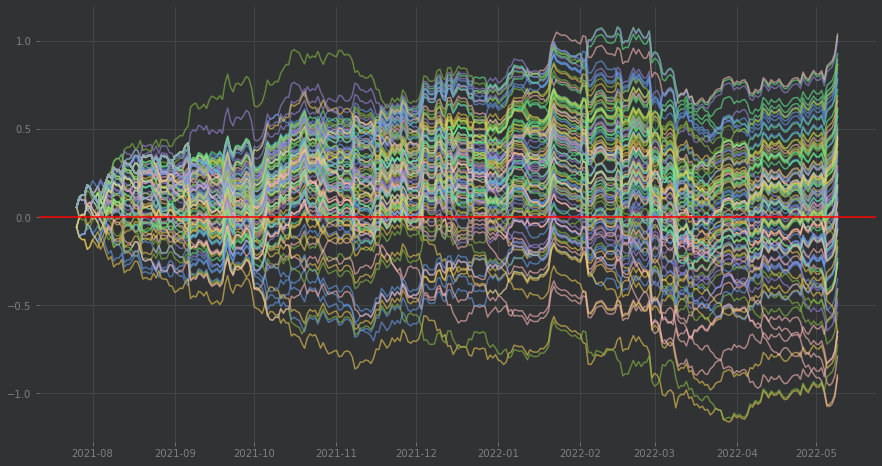

In [71]:
Ann_return=pd.DataFrame(return_test,index=[f"Ann n{i}"for i in range(len(return_test))]).transpose()

plt.figure(figsize=(15,8))

plt.plot(Ann_return.cumsum(axis=0),alpha=0.6)

plt.axhline(0,color="red")

plt.show()



## RNN

In [22]:
def X_3d_Rnn(x_s,y_s,lag):
    if len(x_s)!= len(y_s):
        print(Warning)
        
    xtrain=[]
    for variable in range(0,x_s.shape[1]):
        x=[]
        for i in range(lag,x_s.shape[0]):
            x.append(x_s[i-lag:i,variable])
        xtrain.append(x)
        xtrain, np.array(xtrain)
        xtrain=np.swapaxes(np.swapaxes(xtrain,0,1),1,2)
        ytrain=[]
        for i in range(lag,y_s.shape[0]):
            ytrain.append(y_s[i,:].reshape(-1,1).transpose())
        ytrain=np.concatenate(ytrain,axis=0)
        return xtrain,ytrain
    
    
    

In [23]:
lag = 15
xtrain_3d,ytrain_3d=X_3d_Rnn(xtrain_sc,ytrain.values,lag)
xtest_3d,ytest_3d=X_3d_Rnn(xtest_sc,ytest.values,lag)


In [24]:
pd.DataFrame(xtrain_3d[0])

,0
0,-0.652595
1,-0.652253
2,-0.651914
3,-0.651652
4,-0.651376
5,-0.651275
6,-0.651267
7,-0.651209
8,-0.651087
9,-0.651012


In [25]:
np.shape(ytrain_3d)

(2429, 1)

In [26]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from tensorflow.keras.callbacks import EarlyStopping 

In [27]:
nb_hidden_layers=3
classifier=Sequential()

In [28]:
classifier.add(LSTM(units=10, return_sequences=True,
                    input_shape=(xtrain_3d.shape[1],xtrain_3d.shape[2],)))

for _ in range(1):
    classifier.add(LSTM(units=10,return_sequences=True))
    classifier.add(Dropout(0.15))
    


In [29]:
classifier.add(LSTM(units=10,return_sequences=False))

classifier.add(Dense(1,activation="sigmoid"))

In [30]:
classifier.compile(loss="binary_crossentropy",optimizer="adam")

In [31]:
early_stop = EarlyStopping(verbose=1,patience=5)
classifier.fit(xtrain_3d,ytrain_3d,validation_data=(xtest_3d,ytest_3d),epochs=50,callbacks=[early_stop])

Epoch 1/50
76/76 [==============================] - 8s 32ms/step - loss: 0.3542 - val_loss: 0.0552
Epoch 2/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0307 - val_loss: 0.0070
Epoch 3/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0213 - val_loss: 0.0012
Epoch 4/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0196 - val_loss: -0.0012
Epoch 5/50
76/76 [==============================] - 1s 15ms/step - loss: 0.0190 - val_loss: -0.0026
Epoch 6/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0188 - val_loss: -0.0036
Epoch 7/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0186 - val_loss: -0.0041
Epoch 8/50
76/76 [==============================] - 1s 16ms/step - loss: 0.0184 - val_loss: -0.0044
Epoch 9/50
76/76 [==============================] - 1s 15ms/step - loss: 0.0185 - val_loss: -0.0048
Epoch 10/50
76/76 [==============================] - 1s 17ms/step - loss: 0.0184 - val_loss: -0.0051
Ep

In [32]:
y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(xtrain_3d)),
                               axis=0)
y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(xtest_3d)),
                              axis=0)

In [33]:
dfc['prediction']= np.concatenate((y_pred_train,y_pred_test),axis=0)

In [34]:
dfc['prediction']=np.where(dfc['prediction']<0.5,-1,1)

In [35]:
dfc['strategy'] = np.sign(dfc['prediction'].shift(1))*dfc['volume']

In [36]:
print(f"xtrain_3d:{np.shape(xtrain_3d)}")
print(f"xtest_3d:{np.shape(xtest_3d)}")
print(f"X:{np.shape(dfc)}")

xtrain_3d:(2429, 15, 1)
xtest_3d:(417, 15, 1)
X:(2876, 12)


<AxesSubplot:xlabel='time'>

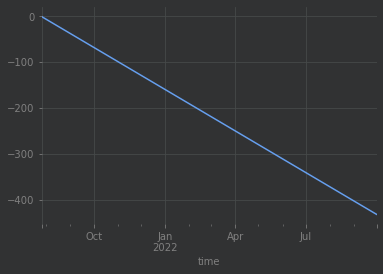

In [37]:
dfc['prediction'].iloc[split:].cumsum().plot()

In [41]:
def feature_eng(df):
    df_copy=df.copy()
    df_copy["volume"]=df["close"].pct_change(1)
    df_copy["dummy"]=np.round(df["volume"]+0.5)
    df_copy["SMA 15"] = df[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df[["close"]].rolling(60).mean().shift(1)
    df_copy["MSD 10"] = df[["volume"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df[["volume"]].rolling(30).std().shift(1)
    Rsi=ta.momentum.RSIIndicator(df["close"],window=14,fillna=False)
    df_copy["rsi"]=Rsi.rsi()
    return df_copy.dropna()

def preprocessing(symbol):
    ticker_list=["ETH-USD"]
    df=yf.download(ticker_list).dropna()
    df.columns=['open','high','low','close','adj close','volume']
    df.index.name = 'time'
    del df['adj close']
    return df


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping 
def Rnn(symbol,nb_neuron=10,nb_hidden_layers=1,lag=15,nb_model=None):
    df= preprocessing(symbol)
    dfc=feature_eng(df)
    split=int(0.85*len(dfc))
    split_val=int(0.95*len(dfc))

    xtrain=dfc[['SMA 15', 'SMA 60', 'MSD 10','MSD 30', 'rsi']].iloc[:split:,:]
    ytrain=dfc[["dummy"]].iloc[:split:,:]


    xtest=dfc[['SMA 15', 'SMA 60', 'MSD 10','MSD 30', 'rsi']].iloc[split:,:]
    ytest=dfc[["dummy"]].iloc[split:,:]
    
    from sklearn.preprocessing import StandardScaler
    sc= StandardScaler()

    xtrain_sc= sc.fit_transform(xtrain)
    xtest_sc= sc.transform(xtest)
    
    
    classifier=Sequential()
    classifier.add(LSTM(units=10, return_sequences=True,
                    input_shape=(xtrain_3d.shape[1],xtrain_3d.shape[2],)))

    for _ in range(1):
        classifier.add(LSTM(units=10,return_sequences=True))
        classifier.add(Dropout(0.15))
    classifier.add(LSTM(units=10,return_sequences=False))

    classifier.add(Dense(1,activation="sigmoid"))
    classifier.compile(loss="binary_crossentropy",optimizer="adam")
    early_stop = EarlyStopping(verbose=1,patience=5)
    classifier.fit(xtrain_3d,ytrain_3d,validation_data=(xtest_3d,ytest_3d),epochs=50,callbacks=[early_stop])
    y_pred_train = np.concatenate((np.zeros([lag,1]),classifier.predict(xtrain_3d)),
                               axis=0)
    y_pred_test = np.concatenate((np.zeros([lag,1]),classifier.predict(xtest_3d)),
                              axis=0)
    dfc['prediction']= np.concatenate((y_pred_train,y_pred_test),axis=0)
    dfc['prediction']=np.where(dfc['prediction']<0.5,-1,1)
    dfc['strategy'] = np.sign(dfc['prediction'].shift(1))*dfc['volume']
    
   
    if nb_model!=None:
        classifier.save_weights(f"Weigth_Rnn/Rnn n{nb_model}")
        return dfc['strategy'].iloc[split+lag:split_val], dfc['strategy'].iloc[split_val:]
    else:
        return dfc['strategy'].iloc[split+lag:split_val], dfc['strategy'].iloc[split_val:]

In [42]:
sr =Rnn("ETH-USD",nb_model=15)
sr

[*********************100%***********************]  1 of 1 completed
Epoch 1/50
76/76 [==============================] - 9s 34ms/step - loss: 0.3159 - val_loss: 0.0957
Epoch 2/50
76/76 [==============================] - 1s 17ms/step - loss: 0.0304 - val_loss: 0.0093
Epoch 3/50
76/76 [==============================] - 1s 17ms/step - loss: 0.0217 - val_loss: 0.0025
Epoch 4/50
76/76 [==============================] - 1s 19ms/step - loss: 0.0200 - val_loss: -7.4151e-04
Epoch 5/50
76/76 [==============================] - 1s 19ms/step - loss: 0.0192 - val_loss: -0.0022
Epoch 6/50
76/76 [==============================] - 1s 19ms/step - loss: 0.0189 - val_loss: -0.0033
Epoch 7/50
76/76 [==============================] - 1s 18ms/step - loss: 0.0187 - val_loss: -0.0041
Epoch 8/50
76/76 [==============================] - 1s 18ms/step - loss: 0.0185 - val_loss: -0.0046- loss: 0
Epoch 9/50
76/76 [==============================] - 1s 19ms/step - loss: 0.0185 - val_loss: -0.0049
Epoch 10/50
76/76 [==

ValueError: Length of values (2876) does not match length of index (1727)

## Binance udemy

In [58]:
import os
import sqlalchemy
import pandas as pd
from binance.client import Client
from binance.enums import *
from binance.exceptions import BinanceAPIException, BinanceOrderException

In [59]:
client =Client("yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe","lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO")

In [60]:

client.ping()

{}

In [61]:
client.get_system_status()

{'status': 0, 'msg': 'normal'}

In [62]:
account=client.get_account()
account

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'brokered': False,
 'updateTime': 1665480220128,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.06165400', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '0

In [63]:
account["accountType"]

'SPOT'

In [64]:
pd.to_datetime(account["updateTime"],unit="ms")

Timestamp('2022-10-11 09:23:40.128000')

In [65]:
account["balances"]

[{'asset': 'BTC', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'ETH', 'free': '0.06165400', 'locked': '0.00000000'},
 {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'BNB', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'USDT', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'HSR', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'OAX', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'DNT', 'free': '0.00000000', 'locked': '0.00000000'},
 {'asset': 'MCO', 'free

In [66]:
df=pd.DataFrame(account["balances"])
df

,asset,free,locked
0,BTC,0.00000000,0.00000000
1,LTC,0.00000000,0.00000000
2,ETH,0.06165400,0.00000000
3,NEO,0.00000000,0.00000000
4,BNB,0.00000000,0.00000000
...,...,...,...
513,OP,0.00000000,0.00000000
514,LEVER,0.00000000,0.00000000
515,STG,0.00000000,0.00000000
516,ETHW,0.00003090,0.00000000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   asset   518 non-null    object
 1   free    518 non-null    object
 2   locked  518 non-null    object
dtypes: object(3)
memory usage: 12.3+ KB


In [68]:
df.free=pd.to_numeric(df.free, errors="coerce")
df.locked=pd.to_numeric(df.locked,errors="coerce")

In [69]:
df.loc[df.free>0]

,asset,free,locked
2,ETH,0.061654,0.0
188,BUSD,19.691246,0.0
516,ETHW,0.000031,0.0


In [70]:
client.get_asset_balance(asset='ETH')


{'asset': 'ETH', 'free': '0.06165400', 'locked': '0.00000000'}

In [71]:
client.get_asset_balance(asset='BTC')

{'asset': 'BTC', 'free': '0.00000000', 'locked': '0.00000000'}

In [72]:
float(client.get_asset_balance(asset='ETH')['free'])


0.061654

In [73]:
snap = client.get_account_snapshot(type ='SPOT')
snap

{'code': 200,
 'msg': '',
 'snapshotVos': [{'type': 'spot',
   'updateTime': 1664927999000,
   'data': {'totalAssetOfBtc': '0.00103409',
    'balances': [{'asset': 'BNB', 'free': '0', 'locked': '0'},
     {'asset': 'BUSD', 'free': '0.08517295', 'locked': '79.8336'},
     {'asset': 'ETH', 'free': '0.015385', 'locked': '0'},
     {'asset': 'ETHW', 'free': '0.0000309', 'locked': '0'},
     {'asset': 'EUR', 'free': '0', 'locked': '0'},
     {'asset': 'USDT', 'free': '0', 'locked': '0'}]}},
  {'type': 'spot',
   'updateTime': 1665014399000,
   'data': {'totalAssetOfBtc': '0.00103622',
    'balances': [{'asset': 'BNB', 'free': '0', 'locked': '0'},
     {'asset': 'BUSD', 'free': '0.08517295', 'locked': '79.8336'},
     {'asset': 'ETH', 'free': '0.015385', 'locked': '0'},
     {'asset': 'ETHW', 'free': '0.0000309', 'locked': '0'},
     {'asset': 'EUR', 'free': '0', 'locked': '0'},
     {'asset': 'USDT', 'free': '0', 'locked': '0'}]}},
  {'type': 'spot',
   'updateTime': 1665100799000,
   'data

In [74]:
snap = pd.json_normalize(snap["snapshotVos"])
snap

,type,updateTime,data.totalAssetOfBtc,data.balances
0,spot,1664927999000,0.00103409,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
1,spot,1665014399000,0.00103622,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
2,spot,1665100799000,0.00104655,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
3,spot,1665187199000,0.00105285,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
4,spot,1665273599000,0.00104666,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
5,spot,1665359999000,0.00105137,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
6,spot,1665446399000,0.0051958,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."


In [75]:
snap.updateTime = pd.to_datetime(snap["updateTime"],unit='ms')
snap

,type,updateTime,data.totalAssetOfBtc,data.balances
0,spot,2022-10-04 23:59:59,0.00103409,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
1,spot,2022-10-05 23:59:59,0.00103622,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
2,spot,2022-10-06 23:59:59,0.00104655,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
3,spot,2022-10-07 23:59:59,0.00105285,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
4,spot,2022-10-08 23:59:59,0.00104666,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
5,spot,2022-10-09 23:59:59,0.00105137,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."
6,spot,2022-10-10 23:59:59,0.0051958,"[{'asset': 'BNB', 'free': '0', 'locked': '0'},..."


In [76]:
snap["data.balances"][0]

[{'asset': 'BNB', 'free': '0', 'locked': '0'},
 {'asset': 'BUSD', 'free': '0.08517295', 'locked': '79.8336'},
 {'asset': 'ETH', 'free': '0.015385', 'locked': '0'},
 {'asset': 'ETHW', 'free': '0.0000309', 'locked': '0'},
 {'asset': 'EUR', 'free': '0', 'locked': '0'},
 {'asset': 'USDT', 'free': '0', 'locked': '0'}]

In [77]:
client.get_exchange_info()["rateLimits"]

[{'rateLimitType': 'REQUEST_WEIGHT',
  'interval': 'MINUTE',
  'intervalNum': 1,
  'limit': 1200},
 {'rateLimitType': 'ORDERS',
  'interval': 'SECOND',
  'intervalNum': 10,
  'limit': 50},
 {'rateLimitType': 'ORDERS',
  'interval': 'DAY',
  'intervalNum': 1,
  'limit': 160000},
 {'rateLimitType': 'RAW_REQUESTS',
  'interval': 'MINUTE',
  'intervalNum': 5,
  'limit': 6100}]

In [78]:
client.get_all_coins_info()

[{'coin': 'AGLD',
  'depositAllEnable': True,
  'withdrawAllEnable': True,
  'name': 'Adventure Gold',
  'free': '0',
  'locked': '0',
  'freeze': '0',
  'withdrawing': '0',
  'ipoing': '0',
  'ipoable': '0',
  'storage': '0',
  'isLegalMoney': False,
  'trading': True,
  'networkList': [{'network': 'ETH',
    'coin': 'AGLD',
    'withdrawIntegerMultiple': '0.00000001',
    'isDefault': True,
    'depositEnable': True,
    'withdrawEnable': True,
    'depositDesc': '',
    'withdrawDesc': '',
    'specialTips': '',
    'specialWithdrawTips': '',
    'name': 'Ethereum (ERC20)',
    'resetAddressStatus': False,
    'addressRegex': '^(0x)[0-9A-Fa-f]{40}$',
    'addressRule': '',
    'memoRegex': '',
    'withdrawFee': '9.78',
    'withdrawMin': '19',
    'withdrawMax': '9999999',
    'minConfirm': 12,
    'unLockConfirm': 0,
    'sameAddress': False,
    'estimatedArrivalTime': 5,
    'busy': False,
    'country': 'AE,BINANCE_BAHRAIN_BSC'}]},
 {'coin': 'STPT',
  'depositAllEnable': True,


In [79]:
coins = pd.DataFrame(client.get_all_coins_info())

In [80]:
coins

,coin,depositAllEnable,withdrawAllEnable,name,free,locked,freeze,withdrawing,ipoing,ipoable,storage,isLegalMoney,trading,networkList
0,AGLD,True,True,Adventure Gold,0,0,0,0,0,0,0,False,True,"[{'network': 'ETH', 'coin': 'AGLD', 'withdrawI..."
1,STPT,True,True,Standard Tokenization Protocol,0,0,0,0,0,0,0,False,True,"[{'network': 'ETH', 'coin': 'STPT', 'withdrawI..."
2,MXN,True,True,Mexican Peso,0,0,0,0,0,0,0,True,False,"[{'network': 'FIAT_MONEY', 'coin': 'MXN', 'wit..."
3,UGX,True,True,Uganda Shilling,0,0,0,0,0,0,0,True,False,"[{'network': 'FIAT_MONEY', 'coin': 'UGX', 'wit..."
4,RENBTC,False,False,renBTC,0,0,0,0,0,0,0,False,False,"[{'network': 'BSC', 'coin': 'RENBTC', 'withdra..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NZD,True,True,New Zealand Dollar,0,0,0,0,0,0,0,True,False,"[{'network': 'FIAT_MONEY', 'coin': 'NZD', 'wit..."
593,MOVR,True,True,Moonriver,0,0,0,0,0,0,0,False,True,"[{'network': 'MOVR', 'coin': 'MOVR', 'withdraw..."
594,XMR,True,True,Monero,0,0,0,0,0,0,0,False,True,"[{'network': 'XMR', 'coin': 'XMR', 'withdrawIn..."
595,1INCHDOWN,False,False,1INCHDOWN,0,0,0,0,0,0,0,False,False,"[{'network': 'ETF', 'coin': '1INCHDOWN', 'with..."


In [81]:
coins.loc[coins.coin=="BTC"]

,coin,depositAllEnable,withdrawAllEnable,name,free,locked,freeze,withdrawing,ipoing,ipoable,storage,isLegalMoney,trading,networkList
352,BTC,True,True,Bitcoin,0,0,0,0,0,0,0,False,True,"[{'network': 'BSC', 'coin': 'BTC', 'withdrawIn..."


In [82]:
coins.loc[coins.coin=="ETH"]

,coin,depositAllEnable,withdrawAllEnable,name,free,locked,freeze,withdrawing,ipoing,ipoable,storage,isLegalMoney,trading,networkList
237,ETH,True,True,Ethereum,0.061654,0,0,0,0,0,0,False,True,"[{'network': 'BSC', 'coin': 'ETH', 'withdrawIn..."


In [83]:
client.get_trade_fee(symbols ="ETHBUSD")

[{'symbol': '1INCHBTC',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHBUSD', 'makerCommission': '0', 'takerCommission': '0.001'},
 {'symbol': '1INCHDOWNUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHUPUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEBKRW',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEBNB', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBRL', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBTC', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBUSD', 'makerCommission': '0', 'takerCommission': '0.001'},
 {'symbol': 'AAVEDOWNUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEETH', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {

In [84]:
client.get_trade_fee(symbols ="ETHBUSD")

[{'symbol': '1INCHBTC',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHBUSD', 'makerCommission': '0', 'takerCommission': '0.001'},
 {'symbol': '1INCHDOWNUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHUPUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEBKRW',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEBNB', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBRL', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBTC', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBUSD', 'makerCommission': '0', 'takerCommission': '0.001'},
 {'symbol': 'AAVEDOWNUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEETH', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {

In [85]:
client.get_trade_fee(symbols ="BTCEUR")

[{'symbol': '1INCHBTC',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHBUSD', 'makerCommission': '0', 'takerCommission': '0.001'},
 {'symbol': '1INCHDOWNUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHUPUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': '1INCHUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEBKRW',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEBNB', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBRL', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBTC', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {'symbol': 'AAVEBUSD', 'makerCommission': '0', 'takerCommission': '0.001'},
 {'symbol': 'AAVEDOWNUSDT',
  'makerCommission': '0.001',
  'takerCommission': '0.001'},
 {'symbol': 'AAVEETH', 'makerCommission': '0.001', 'takerCommission': '0.001'},
 {

In [86]:
client.get_symbol_ticker(symbol="ETHBUSD")

{'symbol': 'ETHBUSD', 'price': '1279.18000000'}

In [87]:
float(client.get_symbol_ticker(symbol="ETHBUSD")['price'])

1279.18

In [88]:
client.get_avg_price(symbol="ETHBUSD")

{'mins': 5, 'price': '1279.90509856'}

In [89]:
prices = client.get_all_tickers()
prices

[{'symbol': 'ETHBTC', 'price': '0.06712900'},
 {'symbol': 'LTCBTC', 'price': '0.00271500'},
 {'symbol': 'BNBBTC', 'price': '0.01421100'},
 {'symbol': 'NEOBTC', 'price': '0.00042400'},
 {'symbol': 'QTUMETH', 'price': '0.00212600'},
 {'symbol': 'EOSETH', 'price': '0.00081500'},
 {'symbol': 'SNTETH', 'price': '0.00002097'},
 {'symbol': 'BNTETH', 'price': '0.00034200'},
 {'symbol': 'BCCBTC', 'price': '0.07908100'},
 {'symbol': 'GASBTC', 'price': '0.00011450'},
 {'symbol': 'BNBETH', 'price': '0.21180000'},
 {'symbol': 'BTCUSDT', 'price': '19055.80000000'},
 {'symbol': 'ETHUSDT', 'price': '1279.21000000'},
 {'symbol': 'HSRBTC', 'price': '0.00041400'},
 {'symbol': 'OAXETH', 'price': '0.00017780'},
 {'symbol': 'DNTETH', 'price': '0.00002801'},
 {'symbol': 'MCOETH', 'price': '0.00577200'},
 {'symbol': 'ICNETH', 'price': '0.00166300'},
 {'symbol': 'MCOBTC', 'price': '0.00021140'},
 {'symbol': 'WTCBTC', 'price': '0.00001515'},
 {'symbol': 'WTCETH', 'price': '0.00023700'},
 {'symbol': 'LRCBTC', 'p

In [90]:
df=pd.DataFrame(prices)
df

,symbol,price
0,ETHBTC,0.06712900
1,LTCBTC,0.00271500
2,BNBBTC,0.01421100
3,NEOBTC,0.00042400
4,QTUMETH,0.00212600
...,...,...
2099,PROSBUSD,0.73710000
2100,VIBBUSD,0.06313000
2101,GMXBTC,0.00208800
2102,GMXBUSD,39.75000000


In [91]:
df[df.symbol.str.contains("ETHBUSD")]

,symbol,price
632,ETHBUSD,1279.18000000
2091,BETHBUSD,1252.52000000


In [92]:
df[df.symbol.str.contains("BTC")&df.symbol.str.contains("USD")]

,symbol,price
11,BTCUSDT,19055.80000000
312,BTCTUSD,19446.02000000
313,TUSDBTC,0.00025971
417,BTCUSDC,19440.48000000
454,BTCUSDS,9604.59000000
614,BTCBUSD,19053.80000000
795,BTCUPUSDT,3.75000000
796,BTCDOWNUSDT,0.03541300
1190,SUSDBTC,0.00002065
1240,BTCSTBUSD,8.78000000


In [93]:
df[df.symbol.str.contains("ETHB") & df.symbol.str.contains("USD")]

,symbol,price
632,ETHBUSD,1279.18000000
705,ETHBULLUSDT,79.18000000
706,ETHBULLBUSD,78.46000000
707,ETHBEARUSDT,12.20000000
708,ETHBEARBUSD,12.24000000
2091,BETHBUSD,1252.52000000


In [94]:
last24hrs=client.get_ticker(symbol='ETHBUSD')
last24hrs

{'symbol': 'ETHBUSD',
 'priceChange': '-34.84000000',
 'priceChangePercent': '-2.651',
 'weightedAvgPrice': '1294.50559643',
 'prevClosePrice': '1314.00000000',
 'lastPrice': '1279.16000000',
 'lastQty': '0.02000000',
 'bidPrice': '1279.16000000',
 'bidQty': '100.67280000',
 'askPrice': '1279.17000000',
 'askQty': '2.40730000',
 'openPrice': '1314.00000000',
 'highPrice': '1320.00000000',
 'lowPrice': '1267.35000000',
 'volume': '305971.21620000',
 'quoteVolume': '396081451.71625500',
 'openTime': 1665396383502,
 'closeTime': 1665482783502,
 'firstId': 406431574,
 'lastId': 406726379,
 'count': 294806}

In [95]:
last24hrs['openTime']

1665396383502

In [96]:
pd.to_datetime(last24hrs["openTime"],unit='ms')

Timestamp('2022-10-10 10:06:23.502000')

In [97]:
pd.to_datetime(last24hrs["closeTime"],unit='ms')

Timestamp('2022-10-11 10:06:23.502000')

In [98]:
openprice=float(last24hrs["openPrice"])
openprice

1314.0

In [99]:
highprice=float(last24hrs["highPrice"])
highprice

1320.0

In [100]:
lowprice=float(last24hrs["lowPrice"])
lowprice

1267.35

In [101]:
closeprice=float(last24hrs["lastPrice"])
closeprice

1279.16

In [102]:
closeprice - openprice 

-34.83999999999992

In [103]:
(closeprice/openprice -1) *100

-2.651445966514454

In [104]:
timestamp = client._get_earliest_valid_timestamp(symbol = "ETHBUSD",interval="1d")
timestamp

1571616000000

In [105]:
pd.to_datetime(timestamp,unit="ms")

Timestamp('2019-10-21 00:00:00')

In [106]:
bars= client.get_historical_klines(symbol="ETHBUSD",interval="1d",start_str=timestamp,limit=1000)

In [107]:
bars

[[1571616000000,
  '175.00000000',
  '177.89000000',
  '171.87000000',
  '174.29000000',
  '460.13617000',
  1571702399999,
  '80494.81821450',
  691,
  '148.52806000',
  '26088.87787940',
  '0'],
 [1571702400000,
  '174.24000000',
  '175.13000000',
  '170.34000000',
  '171.31000000',
  '647.82578000',
  1571788799999,
  '112352.32730800',
  776,
  '215.95471000',
  '37433.06192100',
  '0'],
 [1571788800000,
  '171.24000000',
  '171.53000000',
  '153.36000000',
  '162.46000000',
  '1130.90732000',
  1571875199999,
  '183037.24913970',
  1382,
  '389.84541000',
  '62577.30409110',
  '0'],
 [1571875200000,
  '162.34000000',
  '163.50000000',
  '158.44000000',
  '161.00000000',
  '808.86735000',
  1571961599999,
  '130011.07497750',
  1155,
  '46.65817000',
  '7517.50399080',
  '0'],
 [1571961600000,
  '161.02000000',
  '186.73000000',
  '161.00000000',
  '181.74000000',
  '1762.18861000',
  1572047999999,
  '305820.57670970',
  2228,
  '701.09920000',
  '123146.69604840',
  '0'],
 [15720

In [108]:
df=pd.DataFrame(bars)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1571616000000,175.00000000,177.89000000,171.87000000,174.29000000,460.13617000,1571702399999,80494.81821450,691,148.52806000,26088.87787940,0
1,1571702400000,174.24000000,175.13000000,170.34000000,171.31000000,647.82578000,1571788799999,112352.32730800,776,215.95471000,37433.06192100,0
2,1571788800000,171.24000000,171.53000000,153.36000000,162.46000000,1130.90732000,1571875199999,183037.24913970,1382,389.84541000,62577.30409110,0
3,1571875200000,162.34000000,163.50000000,158.44000000,161.00000000,808.86735000,1571961599999,130011.07497750,1155,46.65817000,7517.50399080,0
4,1571961600000,161.02000000,186.73000000,161.00000000,181.74000000,1762.18861000,1572047999999,305820.57670970,2228,701.09920000,123146.69604840,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1082,1665100800000,1352.27000000,1361.78000000,1317.72000000,1331.06000000,391771.53000000,1665187199999,524727900.77756000,338481,193896.62650000,259778239.73607600,0
1083,1665187200000,1331.07000000,1337.47000000,1304.00000000,1315.53000000,204201.77160000,1665273599999,270367660.41910100,152759,98703.49180000,130706599.50737500,0
1084,1665273600000,1315.53000000,1329.00000000,1307.53000000,1323.34000000,168805.35870000,1665359999999,222773621.48586200,144543,85059.32650000,112268172.76445000,0
1085,1665360000000,1323.34000000,1338.23000000,1287.47000000,1290.10000000,311134.05770000,1665446399999,407767281.64215600,280290,153268.65040000,200931675.88990100,0


In [109]:
df['Data']=pd.to_datetime(df.iloc[:,0],unit='ms')

In [110]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,Data
0,1571616000000,175.00000000,177.89000000,171.87000000,174.29000000,460.13617000,1571702399999,80494.81821450,691,148.52806000,26088.87787940,0,2019-10-21
1,1571702400000,174.24000000,175.13000000,170.34000000,171.31000000,647.82578000,1571788799999,112352.32730800,776,215.95471000,37433.06192100,0,2019-10-22
2,1571788800000,171.24000000,171.53000000,153.36000000,162.46000000,1130.90732000,1571875199999,183037.24913970,1382,389.84541000,62577.30409110,0,2019-10-23
3,1571875200000,162.34000000,163.50000000,158.44000000,161.00000000,808.86735000,1571961599999,130011.07497750,1155,46.65817000,7517.50399080,0,2019-10-24
4,1571961600000,161.02000000,186.73000000,161.00000000,181.74000000,1762.18861000,1572047999999,305820.57670970,2228,701.09920000,123146.69604840,0,2019-10-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,1665100800000,1352.27000000,1361.78000000,1317.72000000,1331.06000000,391771.53000000,1665187199999,524727900.77756000,338481,193896.62650000,259778239.73607600,0,2022-10-07
1083,1665187200000,1331.07000000,1337.47000000,1304.00000000,1315.53000000,204201.77160000,1665273599999,270367660.41910100,152759,98703.49180000,130706599.50737500,0,2022-10-08
1084,1665273600000,1315.53000000,1329.00000000,1307.53000000,1323.34000000,168805.35870000,1665359999999,222773621.48586200,144543,85059.32650000,112268172.76445000,0,2022-10-09
1085,1665360000000,1323.34000000,1338.23000000,1287.47000000,1290.10000000,311134.05770000,1665446399999,407767281.64215600,280290,153268.65040000,200931675.88990100,0,2022-10-10


In [111]:
df.columns=["opentime","open","high","low","close","volume","clos Time","quote asset volume","number of trades","taker buy base asset volume","taker buy base asset volume","ignore" ,"date" ]

In [112]:
df

,opentime,open,high,low,close,volume,clos Time,quote asset volume,number of trades,taker buy base asset volume,taker buy base asset volume,ignore,date
0,1571616000000,175.00000000,177.89000000,171.87000000,174.29000000,460.13617000,1571702399999,80494.81821450,691,148.52806000,26088.87787940,0,2019-10-21
1,1571702400000,174.24000000,175.13000000,170.34000000,171.31000000,647.82578000,1571788799999,112352.32730800,776,215.95471000,37433.06192100,0,2019-10-22
2,1571788800000,171.24000000,171.53000000,153.36000000,162.46000000,1130.90732000,1571875199999,183037.24913970,1382,389.84541000,62577.30409110,0,2019-10-23
3,1571875200000,162.34000000,163.50000000,158.44000000,161.00000000,808.86735000,1571961599999,130011.07497750,1155,46.65817000,7517.50399080,0,2019-10-24
4,1571961600000,161.02000000,186.73000000,161.00000000,181.74000000,1762.18861000,1572047999999,305820.57670970,2228,701.09920000,123146.69604840,0,2019-10-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1082,1665100800000,1352.27000000,1361.78000000,1317.72000000,1331.06000000,391771.53000000,1665187199999,524727900.77756000,338481,193896.62650000,259778239.73607600,0,2022-10-07
1083,1665187200000,1331.07000000,1337.47000000,1304.00000000,1315.53000000,204201.77160000,1665273599999,270367660.41910100,152759,98703.49180000,130706599.50737500,0,2022-10-08
1084,1665273600000,1315.53000000,1329.00000000,1307.53000000,1323.34000000,168805.35870000,1665359999999,222773621.48586200,144543,85059.32650000,112268172.76445000,0,2022-10-09
1085,1665360000000,1323.34000000,1338.23000000,1287.47000000,1290.10000000,311134.05770000,1665446399999,407767281.64215600,280290,153268.65040000,200931675.88990100,0,2022-10-10


In [113]:
df=df[["date","open","high","low","close","volume"]].copy()

In [114]:
df

,date,open,high,low,close,volume
0,2019-10-21,175.00000000,177.89000000,171.87000000,174.29000000,460.13617000
1,2019-10-22,174.24000000,175.13000000,170.34000000,171.31000000,647.82578000
2,2019-10-23,171.24000000,171.53000000,153.36000000,162.46000000,1130.90732000
3,2019-10-24,162.34000000,163.50000000,158.44000000,161.00000000,808.86735000
4,2019-10-25,161.02000000,186.73000000,161.00000000,181.74000000,1762.18861000
...,...,...,...,...,...,...
1082,2022-10-07,1352.27000000,1361.78000000,1317.72000000,1331.06000000,391771.53000000
1083,2022-10-08,1331.07000000,1337.47000000,1304.00000000,1315.53000000,204201.77160000
1084,2022-10-09,1315.53000000,1329.00000000,1307.53000000,1323.34000000,168805.35870000
1085,2022-10-10,1323.34000000,1338.23000000,1287.47000000,1290.10000000,311134.05770000


In [115]:
df.set_index("date",inplace=True)

In [116]:
df

,open,high,low,close,volume
date,,,,,
2019-10-21,175.00000000,177.89000000,171.87000000,174.29000000,460.13617000
2019-10-22,174.24000000,175.13000000,170.34000000,171.31000000,647.82578000
2019-10-23,171.24000000,171.53000000,153.36000000,162.46000000,1130.90732000
2019-10-24,162.34000000,163.50000000,158.44000000,161.00000000,808.86735000
2019-10-25,161.02000000,186.73000000,161.00000000,181.74000000,1762.18861000
...,...,...,...,...,...
2022-10-07,1352.27000000,1361.78000000,1317.72000000,1331.06000000,391771.53000000
2022-10-08,1331.07000000,1337.47000000,1304.00000000,1315.53000000,204201.77160000
2022-10-09,1315.53000000,1329.00000000,1307.53000000,1323.34000000,168805.35870000


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1087 entries, 2019-10-21 to 2022-10-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    1087 non-null   object
 1   high    1087 non-null   object
 2   low     1087 non-null   object
 3   close   1087 non-null   object
 4   volume  1087 non-null   object
dtypes: object(5)
memory usage: 51.0+ KB


In [118]:
for column in df.columns:
    df[column] = pd.to_numeric(df[column],errors ="coerce")

In [119]:
from binance import ThreadedWebsocketManager
import pandas as pd

In [120]:
def streamdata(msg):
    time= pd.to_timedelta(msg['E'],unit="ms")
    price =msg["c"]
    print("Time :{}| Price:{}".format(time,price))

In [121]:
twm = ThreadedWebsocketManager()
twm.start()

In [122]:
twm

<ThreadedWebsocketManager(Thread-8, started 5900)>

In [123]:
twm.start_symbol_miniticker_socket(callback= streamdata,symbol="ETHBUSD")

'ethbusd@miniTicker'

Time :19276 days 10:07:16.212000| Price:1279.14000000
Time :19276 days 10:07:17.142000| Price:1279.14000000
Time :19276 days 10:07:18.210000| Price:1279.14000000
Time :19276 days 10:07:18.399000| Price:1279.10000000
Time :19276 days 10:07:20.148000| Price:1279.10000000


In [124]:
twm.stop()

Time :19276 days 10:07:23.171000| Price:1278.99000000


In [125]:
df=pd.DataFrame(columns=["open","high","low","close","volume","compelete"])
df

,open,high,low,close,volume,compelete


In [126]:
def streamcandles(msg):
    event_time= pd.to_datetime(msg["E"],unit="ms")
    start_time=pd.to_datetime(msg["k"]["t"],unit="ms")
    first   = float(msg["k"]["o"])
    high    = float(msg["k"]["h"])
    low     = float(msg["k"]["l"])
    close   = float(msg["k"]["c"])
    volume  = float(msg["k"]["v"])
    compelete = msg["k"]["x"]
    print("Time :{}| Price:{}".format(event_time,close))
    df.loc[start_time] = [first,high,low,close,volume,compelete]

In [127]:
twm = ThreadedWebsocketManager()
twm.start()

In [128]:
twm.start_kline_socket(callback=streamcandles,symbol="ETHBUSD",interval="1m")

'ethbusd@kline_1m'

Time :2022-10-11 10:07:35.224000| Price:1278.9
Time :2022-10-11 10:07:38.006000| Price:1278.8
Time :2022-10-11 10:07:41.007000| Price:1278.81
Time :2022-10-11 10:07:43.771000| Price:1278.7
Time :2022-10-11 10:07:45.914000| Price:1278.65
Time :2022-10-11 10:07:48.008000| Price:1278.75


In [129]:
twm.stop()

Time :2022-10-11 10:07:50.322000| Price:1278.74


In [130]:
df

,open,high,low,close,volume,compelete
2022-10-11 10:07:00,1279.39,1279.39,1278.51,1278.74,105.8389,False


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2022-10-11 10:07:00 to 2022-10-11 10:07:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1 non-null      float64
 1   high       1 non-null      float64
 2   low        1 non-null      float64
 3   close      1 non-null      float64
 4   volume     1 non-null      float64
 5   compelete  1 non-null      object 
dtypes: float64(5), object(1)
memory usage: 136.0+ bytes


In [132]:
import os
import sqlalchemy
import pandas as pd
from binance.client import Client
from binance.enums import *
from binance.exceptions import BinanceAPIException, BinanceOrderException
from binance import ThreadedWebsocketManager


In [133]:
# api_key="yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe"
# api_secret="lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO"


In [134]:
# client =Client(config.api_key,config.api_secret,testnet=False)
client =Client(api_key="yBSa36G2jCGeYTgebXe3X48fAZm7qsdC6hPRyKbyr1YkUI3sSJsUvRq6FvsGWCOe",api_secret="lX6LU1Lg76805DiFthhl17jjmcSftsocb0JboaJzhRzBIqmgfYaWBMHZ4tvoCPAO",testnet=False)

In [135]:
client.get_account()

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'brokered': False,
 'updateTime': 1665480220128,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.06165400', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '0

### SELLING

In [136]:
order = client.create_order(
    symbol='ETHBUSD',
    side="SELL",
    type="MARKET",
#     timeInForce=TIME_IN_FORCE_GTC,
    quantity=0.0155,
#     price=1296
)

In [137]:
order

{'symbol': 'ETHBUSD',
 'orderId': 5991135099,
 'orderListId': -1,
 'clientOrderId': 'dagytSN9ndZTpckvi4XJNL',
 'transactTime': 1665482891103,
 'price': '0.00000000',
 'origQty': '0.01550000',
 'executedQty': '0.01550000',
 'cummulativeQuoteQty': '19.82589500',
 'status': 'FILLED',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'side': 'SELL',
 'fills': [{'price': '1279.09000000',
   'qty': '0.01550000',
   'commission': '0.01982590',
   'commissionAsset': 'BUSD',
   'tradeId': 406726689}]}

In [138]:
client.get_account()

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'brokered': False,
 'updateTime': 1665482891103,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.04615400', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '0

### BUYing

In [139]:
order = client.create_order(
    symbol='ETHBUSD',
    side="BUY",
    type="MARKET",
#     timeInForce="GTC",
    quantity=0.0155,
#     price='1284'
)

In [140]:
order

{'symbol': 'ETHBUSD',
 'orderId': 5991136211,
 'orderListId': -1,
 'clientOrderId': '6M8zC3G6AP0OcJ4xde0DbT',
 'transactTime': 1665482899766,
 'price': '0.00000000',
 'origQty': '0.01550000',
 'executedQty': '0.01550000',
 'cummulativeQuoteQty': '19.83519500',
 'status': 'FILLED',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'side': 'BUY',
 'fills': [{'price': '1279.69000000',
   'qty': '0.01550000',
   'commission': '0.00001550',
   'commissionAsset': 'ETH',
   'tradeId': 406726724}]}

In [141]:
df=pd.DataFrame(order["fills"])
df

,price,qty,commission,commissionAsset,tradeId
0,1279.69000000,0.01550000,0.00001550,ETH,406726724


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   price            1 non-null      object
 1   qty              1 non-null      object
 2   commission       1 non-null      object
 3   commissionAsset  1 non-null      object
 4   tradeId          1 non-null      int64 
dtypes: int64(1), object(4)
memory usage: 168.0+ bytes


In [143]:
nums_columns=["price","qty","commission"]

In [144]:
for column in nums_columns:
    df[column] =pd.to_numeric(df[column],errors="coerce")

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1 non-null      float64
 1   qty              1 non-null      float64
 2   commission       1 non-null      float64
 3   commissionAsset  1 non-null      object 
 4   tradeId          1 non-null      int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 168.0+ bytes


In [146]:
df.qty.sum()

0.0155

In [147]:
df.price.mul(df.qty).sum()

19.835195000000002

In [148]:
order

{'symbol': 'ETHBUSD',
 'orderId': 5991136211,
 'orderListId': -1,
 'clientOrderId': '6M8zC3G6AP0OcJ4xde0DbT',
 'transactTime': 1665482899766,
 'price': '0.00000000',
 'origQty': '0.01550000',
 'executedQty': '0.01550000',
 'cummulativeQuoteQty': '19.83519500',
 'status': 'FILLED',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'side': 'BUY',
 'fills': [{'price': '1279.69000000',
   'qty': '0.01550000',
   'commission': '0.00001550',
   'commissionAsset': 'ETH',
   'tradeId': 406726724}]}

In [149]:
client.get_account()

{'makerCommission': 10,
 'takerCommission': 10,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': True,
 'canDeposit': True,
 'brokered': False,
 'updateTime': 1665482899766,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '0.06163850', 'locked': '0.00000000'},
  {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNB', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '0

## LIMIT

In [57]:
# order = client.create_order(
#     symbol='ETHBUSD',
#     side="BUY",
#     type="LIMIT",
#     timeInForce="GTC",
#     quantity=0.0155,
#     price='1284.68'
# )

BinanceAPIException: APIError(code=-2010): Account has insufficient balance for requested action.

In [150]:
order

{'symbol': 'ETHBUSD',
 'orderId': 5991136211,
 'orderListId': -1,
 'clientOrderId': '6M8zC3G6AP0OcJ4xde0DbT',
 'transactTime': 1665482899766,
 'price': '0.00000000',
 'origQty': '0.01550000',
 'executedQty': '0.01550000',
 'cummulativeQuoteQty': '19.83519500',
 'status': 'FILLED',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'side': 'BUY',
 'fills': [{'price': '1279.69000000',
   'qty': '0.01550000',
   'commission': '0.00001550',
   'commissionAsset': 'ETH',
   'tradeId': 406726724}]}

## Geting Information


In [151]:
allorder= client.get_all_orders(symbol="ETHBUSD")
allorder

[{'symbol': 'ETHBUSD',
  'orderId': 4291759389,
  'orderListId': -1,
  'clientOrderId': 'web_c53da89361654d19a5d87b6088bcab51',
  'price': '2610.00000000',
  'origQty': '0.01910000',
  'executedQty': '0.01910000',
  'cummulativeQuoteQty': '49.85100000',
  'status': 'FILLED',
  'timeInForce': 'GTC',
  'type': 'TAKE_PROFIT_LIMIT',
  'side': 'BUY',
  'stopPrice': '2610.00000000',
  'icebergQty': '0.00000000',
  'time': 1646596915789,
  'updateTime': 1646596918804,
  'isWorking': True,
  'origQuoteOrderQty': '0.00000000'},
 {'symbol': 'ETHBUSD',
  'orderId': 4292049184,
  'orderListId': -1,
  'clientOrderId': 'web_279e9981698b462988959361f303338b',
  'price': '2630.00000000',
  'origQty': '0.01910000',
  'executedQty': '0.01910000',
  'cummulativeQuoteQty': '50.23300000',
  'status': 'FILLED',
  'timeInForce': 'GTC',
  'type': 'STOP_LOSS_LIMIT',
  'side': 'SELL',
  'stopPrice': '2630.00000000',
  'icebergQty': '0.00000000',
  'time': 1646601215144,
  'updateTime': 1646601235961,
  'isWorki

In [152]:
pd.DataFrame(allorder)

,symbol,orderId,orderListId,clientOrderId,price,origQty,executedQty,cummulativeQuoteQty,status,timeInForce,type,side,stopPrice,icebergQty,time,updateTime,isWorking,origQuoteOrderQty
0,ETHBUSD,4291759389,-1,web_c53da89361654d19a5d87b6088bcab51,2610.00000000,0.01910000,0.01910000,49.85100000,FILLED,GTC,TAKE_PROFIT_LIMIT,BUY,2610.00000000,0.00000000,1646596915789,1646596918804,True,0.00000000
1,ETHBUSD,4292049184,-1,web_279e9981698b462988959361f303338b,2630.00000000,0.01910000,0.01910000,50.23300000,FILLED,GTC,STOP_LOSS_LIMIT,SELL,2630.00000000,0.00000000,1646601215144,1646601235961,True,0.00000000
2,ETHBUSD,4298528182,-1,web_37b1ddd6a4f34d788d0cc8613cbcd196,2585.00000000,0.03860000,0.03860000,99.78100000,FILLED,GTC,TAKE_PROFIT_LIMIT,BUY,2585.00000000,0.00000000,1646673385903,1646673390187,True,0.00000000
3,ETHBUSD,4298995641,-1,web_829081e84fcd46a19232276ed04a70d3,2450.00000000,0.03860000,0.03860000,94.57000000,FILLED,GTC,STOP_LOSS_LIMIT,SELL,2450.00000000,0.00000000,1646677055663,1646683091191,True,0.00000000
4,ETHBUSD,4307508508,-1,web_ac2d9d565a9e4ff0b3486e0cc7257a94,2593.00000000,0.03860000,0.03860000,100.08980000,FILLED,GTC,STOP_LOSS_LIMIT,BUY,2593.00000000,0.00000000,1646761104895,1646761128272,True,0.00000000
5,ETHBUSD,4308164403,-1,web_14c8b87e54f84787ab71049dc471234f,2560.00000000,0.03860000,0.03860000,98.81600000,FILLED,GTC,STOP_LOSS_LIMIT,SELL,2560.00000000,0.00000000,1646767385699,1646767414345,True,0.00000000
6,ETHBUSD,4308401535,-1,web_2d4c1d2a918d4921840c8b40bea2a4bb,2580.00000000,0.03830000,0.03830000,98.81400000,FILLED,GTC,STOP_LOSS_LIMIT,BUY,2580.00000000,0.00000000,1646770546389,1646770562619,True,0.00000000
7,ETHBUSD,4308466825,-1,web_4964a5f9baa54bdb91d3acc884d9a685,2563.00000000,0.03830000,0.03830000,98.16290000,FILLED,GTC,STOP_LOSS_LIMIT,SELL,2563.00000000,0.00000000,1646771445635,1646771471058,True,0.00000000
8,ETHBUSD,4308842850,-1,web_a558aae168d5447182dc3b7c0a381137,2569.00000000,0.03810000,0.03810000,97.87890000,FILLED,GTC,STOP_LOSS_LIMIT,BUY,2569.00000000,0.00000000,1646778054638,1646778060162,True,0.00000000
9,ETHBUSD,4308856662,-1,web_629c203c99f442fa96e3c2d57b453441,2572.00000000,0.03800000,0.03800000,97.73600000,FILLED,GTC,TAKE_PROFIT_LIMIT,SELL,2572.00000000,0.00000000,1646778368531,1646778490211,True,0.00000000


In [153]:
trades=client.get_my_trades(symbol="ETHBUSD")

In [154]:
df=pd.DataFrame(trades)
df

,symbol,id,orderId,orderListId,price,qty,quoteQty,commission,commissionAsset,time,isBuyer,isMaker,isBestMatch
0,ETHBUSD,273710392,4291759389,-1,2610.00000000,0.01910000,49.85100000,0.00000000,BNB,1646596918804,True,True,True
1,ETHBUSD,273720201,4292049184,-1,2630.00000000,0.01880000,49.44400000,0.00000000,BNB,1646601230810,False,True,True
2,ETHBUSD,273720202,4292049184,-1,2630.00000000,0.00030000,0.78900000,0.00000000,BNB,1646601235961,False,True,True
3,ETHBUSD,273980916,4298528182,-1,2585.00000000,0.03860000,99.78100000,0.00000000,BNB,1646673390187,True,True,True
4,ETHBUSD,274038649,4298995641,-1,2450.00000000,0.03860000,94.57000000,0.09457000,BUSD,1646683091191,False,False,True
5,ETHBUSD,274355257,4307508508,-1,2593.00000000,0.03860000,100.08980000,0.00000000,BNB,1646761128272,True,True,True
6,ETHBUSD,274387855,4308164403,-1,2560.00000000,0.03860000,98.81600000,0.00000000,BNB,1646767414345,False,True,True
7,ETHBUSD,274397043,4308401535,-1,2580.00000000,0.03830000,98.81400000,0.00000000,BNB,1646770562619,True,True,True
8,ETHBUSD,274399616,4308466825,-1,2563.00000000,0.03830000,98.16290000,0.00000000,BNB,1646771471058,False,True,True
9,ETHBUSD,274414380,4308842850,-1,2569.00000000,0.03810000,97.87890000,0.00003810,ETH,1646778060162,True,False,True


In [155]:
df.time=pd.to_datetime(df.time,unit="ms",errors="coerce")

In [156]:
twm = ThreadedWebsocketManager()
twm.start()

In [161]:
def simplebot(msg):
    Time=pd.to_datetime(msg["E"],unit="ms")
    Price=float(msg["c"])
    print("Time :{}| Price:{}".format(Time,Price))
    if int(price) %10==0:
        order = client.create_order(symbol='ETHBUSD',side="BUY",type="MARKET",timeInForce="GTC",quantity=0.0154,price=1296)
        print("\n"+50*"-")
        print("Buy {} BTC for {} USD".format(order["executedQty"],order["cummalitiveQuoteQty"]))
        print(50*"-"+"\n")
        
        twm.stop()

In [162]:
twm.start_symbol_miniticker_socket(callback=simplebot,symbol="ETHBUSD")

'ethbusd@miniTicker'

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-108' coro=<ThreadedApiManager.start_listener() done, defined at C:\ProgramData\Anaconda3\lib\site-packages\binance\threaded_stream.py:42> exception=NameError("name 'price' is not defined")>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\binance\threaded_stream.py", line 52, in start_listener
    callback(msg)
  File "<ipython-input-161-5a19ced63ae4>", line 5, in simplebot
    if int(price) %10==0:
NameError: name 'price' is not defined


Time :2022-10-11 10:10:02.292000| Price:1280.59
